In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from stockstats import StockDataFrame 
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data


files=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
  

prices=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    #priceData = get_price_data(param)
    #stock = StockDataFrame.retype(priceData)
    #price = pd.DataFrame(stock)
    #string=['close_2_sma','close_4_sma','close_6_sma','close_8_sma','close_10_sma','close_12_sma','close_14_sma','close_16_sma','close_18_sma','pdi','mdi','dx','adx','adxr','cr','cr-ma1','cr-ma2','cr-ma3','boll','boll_ub','boll_lb','volume_-2_d','volume_-4_d','volume_-6_d','volume_-8_d','volume_-10_d','volume_-12_d','macd','macds','macdh','kdjk','kdjd','kdjj','tr','atr','wr_2','wr_10','wr_6','wr_8','wr_12','wr_14','close_-2_d','close_-4_d','close_-6_d','close_-8_d','close_-10_d','close_-12_d','close_-14_d','close_-16_d','rsi_2','rsi_4','rsi_6','rsi_8','rsi_10','rsi_12','rsi_14','rsi_16']
    #string=['close_2_sma','close_4_sma','close_6_sma','close_8_sma','close_10_sma','close_12_sma','close_14_sma','close_16_sma','close_18_sma','pdi','mdi','dx','adx','adxr','cr','cr-ma1','cr-ma2','cr-ma3','boll','boll_ub','boll_lb','volume_-2_d','volume_-4_d','volume_-6_d','volume_-8_d','volume_-10_d','volume_-12_d','macd','macds','macdh','kdjk','kdjd','kdjj','tr','atr','wr_2','wr_10','wr_6','wr_8','wr_12','wr_14','close_-2_d','close_-4_d','close_-6_d','close_-8_d','close_-10_d','close_-12_d','close_-14_d','close_-16_d','rsi_2','rsi_4','rsi_6','rsi_8','rsi_10','rsi_12','rsi_14','rsi_16']
    #stock.get(string)
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    price=price.drop(['Unnamed: 0'],axis=1)
   
    
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    print(file)
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL
AMZN
PEP
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
BKNG
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d):
    model = Sequential()  
    model.add(Dense(n, input_dim=111,activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
           


Working on... AAPL
15.571701720841297
0.005338458253266777
working on d,u and l 0.5 64 0.05
ok
working on d,u and l 0.5 64 0.01
ok
working on d,u and l 0.5 128 0.05
ok
working on d,u and l 0.5 128 0.01
ok
Chart for BEST MODEL FOR: AAPL


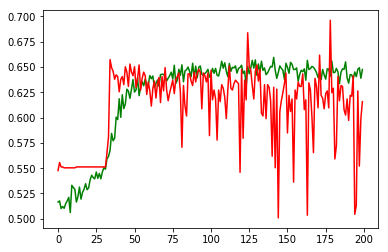

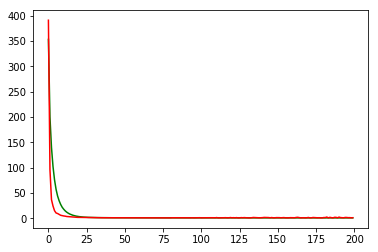

F1,score 0.5256270447110142
G-score: 0.5887986310981375
Accuracy 0.6157243816254417
Window: 140
[[456  52]
 [383 241]]
Vol pos 4.024797226334944
Vol neg 1.7672751090018366
Real Percentage of gain: 95.92063245681318
Percentage of gain: 1.7990450480032307
Total gain: 2036.518994339657
000000000000000000000000000000000000000000000000
Percentile:  0
[[365  19]
 [336  39]]
759/759 [==============================] - 0s 32us/step
[1.105097979503501, 0.5322793148880105]
Percentile:  1
[[43 23]
 [45 39]]
150/150 [==============================] - 0s 36us/step
[0.9116348243753115, 0.5466666666666666]
Percentile:  2
[[48 10]
 [ 1 78]]
137/137 [==============================] - 0s 40us/step
[0.3795483273311253, 0.9197080291970803]
Percentile:  3
[[49]]
49/49 [==============================] - 0s 54us/step
[0.3087843419337759, 1.0]
Percentile:  4
[[35]]
35/35 [==============================] - 0s 101us/step
[0.4382574992520469, 1.0]
000000000000000000000000000000000000000000000000
Working on... AMZ

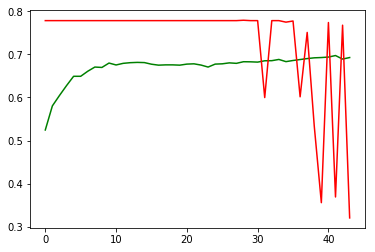

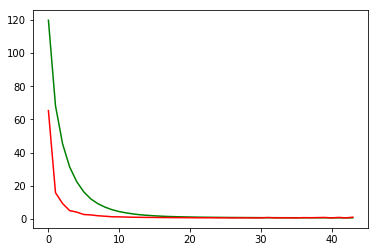

F1,score 0.2989972652689152
G-score: 0.38417017662906017
Accuracy 0.3206713780918728
Window: 140
[[199  52]
 [717 164]]
Vol pos 2.6140371600038215
Vol neg 2.237810579558943
Real Percentage of gain: -190.38793573670546
Percentage of gain: -0.6819618786214136
Total gain: -771.9808465994402
000000000000000000000000000000000000000000000000
Percentile:  0
[[179  20]
 [378  54]]
631/631 [==============================] - 0s 32us/step
[0.9485111708875315, 0.3692551505546751]
Percentile:  1
[[ 11  25]
 [294  55]]
385/385 [==============================] - 0s 35us/step
[1.0330045170598217, 0.17142857142857143]
Percentile:  2
[[ 9  7]
 [43 16]]
75/75 [==============================] - 0s 51us/step
[0.901369702021281, 0.3333333333333333]
Percentile:  3
[[ 0  0]
 [ 2 31]]
33/33 [==============================] - 0s 83us/step
[0.49671653545264044, 0.9393939393939394]
Percentile:  4
[[6]]
6/6 [==============================] - 0s 163us/step
[0.35872209072113037, 1.0]
00000000000000000000000000000000

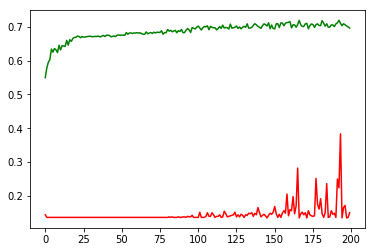

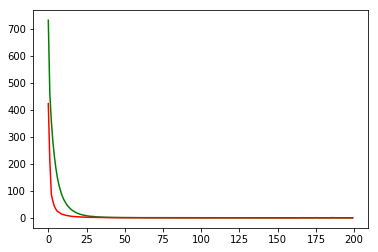

F1,score 0.03819444444444444
G-score: 0.13819959430608314
Accuracy 0.15030674846625766
Window: 140
[[ 87   2]
 [552  11]]
Vol pos 0.7240494693372478
Vol neg 2.3327115835485723
Real Percentage of gain: -114.34870901743292
Percentage of gain: -1.8732597688510104
Total gain: -1221.3653692908588
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 68   2]
 [104   5]]
179/179 [==============================] - 0s 40us/step
[1.0258955755713266, 0.40782122905027934]
Percentile:  1
[[ 19   0]
 [142   4]]
165/165 [==============================] - 0s 41us/step
[1.2934969511899082, 0.1393939393939394]
Percentile:  2
[[  0   0]
 [186   0]]
186/186 [==============================] - 0s 40us/step
[1.343881804455993, 0.0]
Percentile:  3
[[ 0  0]
 [74  2]]
76/76 [==============================] - 0s 51us/step
[1.248076696144907, 0.02631578947368421]
Percentile:  4
[[ 0  0]
 [45  0]]
45/45 [==============================] - 0s 52us/step
[1.2552651829189725, 0.0]
0000000000000000000000000

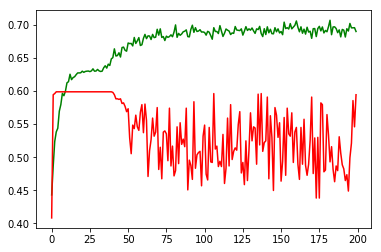

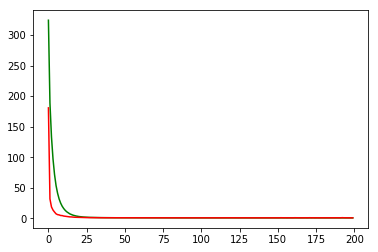

F1,score 0.7451415880066631
G-score: 0.06602881216734027
Accuracy 0.5945229681978799
Window: 140
[[  2 452]
 [  7 671]]
Vol pos 3.3945525983683296
Vol neg 2.288421975284927
Real Percentage of gain: 134.60838054847923
Percentage of gain: 1.090236936436488
Total gain: 1234.1482120461044
000000000000000000000000000000000000000000000000
Percentile:  0
[[  2 229]
 [  5 180]]
416/416 [==============================] - 0s 39us/step
[0.8891327747931848, 0.4375]
Percentile:  1
[[  0 111]
 [  1 248]]
360/360 [==============================] - 0s 42us/step
[0.6759417798784044, 0.6888888888888889]
Percentile:  2
[[  0  97]
 [  0 109]]
206/206 [==============================] - 0s 47us/step
[0.8687956538593885, 0.529126213592233]
Percentile:  3
[[ 0 14]
 [ 1 86]]
101/101 [==============================] - 0s 59us/step
[0.4886270758539143, 0.8514851485148515]
Percentile:  4
[[47]]
47/47 [==============================] - 0s 75us/step
[0.29689778989933907, 1.0]
000000000000000000000000000000000000000

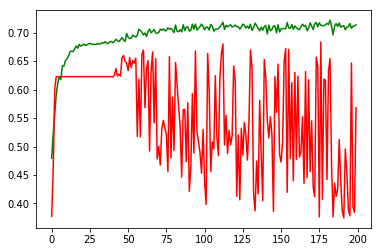

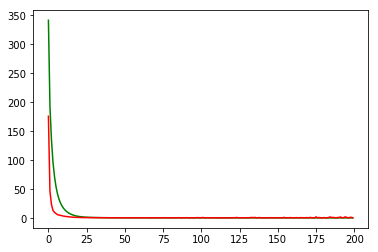

F1,score 0.6298258894776684
G-score: 0.5600813325238039
Accuracy 0.568021198675405
Window: 140
[[227 200]
 [289 416]]
Vol pos 1.5077227745977355
Vol neg 1.645284516274789
Real Percentage of gain: 44.9310293176465
Percentage of gain: 0.14569047315191877
Total gain: 164.92161560797206
000000000000000000000000000000000000000000000000
Percentile:  0
[[198 102]
 [135 114]]
549/549 [==============================] - 0s 54us/step
[0.7497493492232429, 0.5683060109289617]
Percentile:  1
[[ 27  47]
 [ 73 163]]
310/310 [==============================] - 0s 59us/step
[0.6497888036312596, 0.6129032254219056]
Percentile:  2
[[ 1 22]
 [51 89]]
163/163 [==============================] - 0s 64us/step
[0.7005658244794132, 0.5521472392638037]
Percentile:  3
[[ 1 19]
 [27 34]]
81/81 [==============================] - 0s 71us/step
[0.7071188202610722, 0.43209876580002865]
Percentile:  4
[[ 0 10]
 [ 2 16]]
28/28 [==============================] - 0s 75us/step
[0.7294029593467712, 0.5714285969734192]
0000000

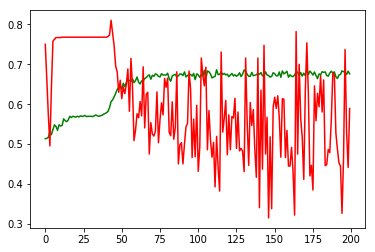

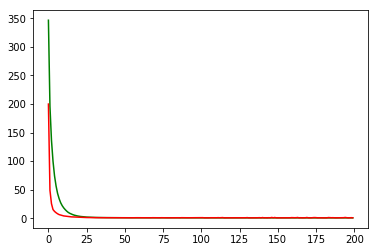

F1,score 0.6782006920415224
G-score: 0.6160229763453241
Accuracy 0.589222614854153
Window: 140
[[177  86]
 [379 490]]
Vol pos 3.2846741574289005
Vol neg 2.7856709919107328
Real Percentage of gain: 4.721680269210728
Percentage of gain: 0.7911136499704822
Total gain: 895.5406517665858
000000000000000000000000000000000000000000000000
Percentile:  0
[[174  38]
 [194 116]]
522/522 [==============================] - 0s 55us/step
[0.71166907690494, 0.5555555555841019]
Percentile:  1
[[  2  35]
 [177 254]]
468/468 [==============================] - 0s 66us/step
[0.856867295045119, 0.5470085470085471]
Percentile:  2
[[ 0 13]
 [ 8 84]]
105/105 [==============================] - 0s 73us/step
[0.6249453567323231, 0.800000000070958]
Percentile:  3
[[14]]
14/14 [==============================] - 0s 131us/step
[0.11186038702726364, 1.0]
Percentile:  4
[[21]]
21/21 [==============================] - 0s 132us/step
[0.11454993486404419, 1.0]
000000000000000000000000000000000000000000000000
Working on...

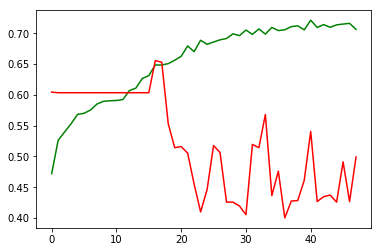

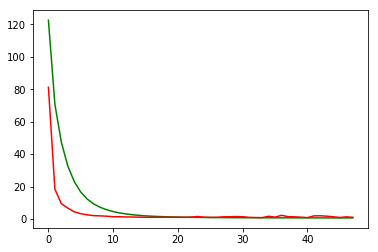

F1,score 0.3961661341853035
G-score: 0.47944915191302645
Accuracy 0.4991166077738516
Window: 140
[[379  70]
 [497 186]]
Vol pos 2.6826475806654004
Vol neg 1.9871727049634573
Real Percentage of gain: -45.241861489034584
Percentage of gain: 0.343612154913137
Total gain: 388.96895936167107
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 88  28]
 [198  40]]
354/354 [==============================] - 0s 70us/step
[1.1890894814399675, 0.3615819209039548]
Percentile:  1
[[ 97  17]
 [163  64]]
341/341 [==============================] - 0s 67us/step
[0.9496384733670618, 0.47214076246334313]
Percentile:  2
[[118   9]
 [ 99  52]]
278/278 [==============================] - 0s 71us/step
[0.7825233292022198, 0.6115107913669064]
Percentile:  3
[[53 10]
 [33 18]]
114/114 [==============================] - 0s 101us/step
[0.7001431662785379, 0.6228070175438597]
Percentile:  4
[[23  6]
 [ 3 11]]
43/43 [==============================] - 0s 124us/step
[0.507685914982197, 0.79069767441860

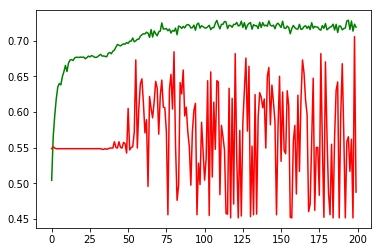

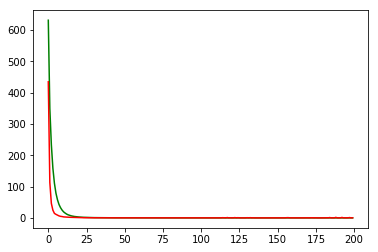

F1,score 0.19220055710306408
G-score: 0.324072262080895
Accuracy 0.4876325113613277
Window: 140
[[483  28]
 [552  69]]
Vol pos 2.1998957507829004
Vol neg 1.5055078991442912
Real Percentage of gain: 69.78228341506338
Percentage of gain: 0.3013673789120778
Total gain: 341.1478729284721
000000000000000000000000000000000000000000000000
Percentile:  0
[[206  25]
 [263  27]]
521/521 [==============================] - 0s 88us/step
[0.9724181642230322, 0.4472168905950096]
Percentile:  1
[[102   3]
 [187  26]]
318/318 [==============================] - 0s 93us/step
[1.034076174849984, 0.40251572364531224]
Percentile:  2
[[64  0]
 [70 11]]
145/145 [==============================] - 0s 87us/step
[0.9199838527317705, 0.5172413805435444]
Percentile:  3
[[58  0]
 [24  4]]
86/86 [==============================] - 0s 117us/step
[0.6050451099872589, 0.7209302325581395]
Percentile:  4
[[52  0]
 [ 5  1]]
58/58 [==============================] - 0s 121us/step
[0.25691576661734744, 0.9137931034482759]
0000

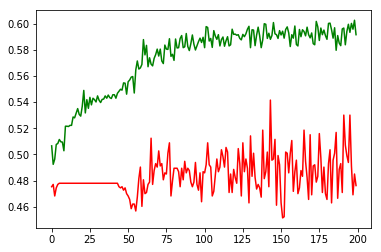

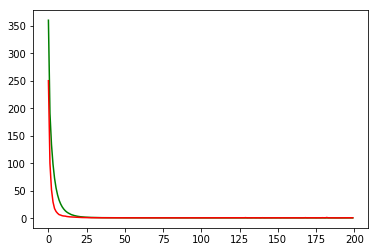

F1,score 0.19319727891156463
G-score: 0.32237379210627787
Accuracy 0.4761484088409073
Window: 140
[[468  73]
 [520  71]]
Vol pos 3.1823693753479265
Vol neg 2.5640568753570263
Real Percentage of gain: -135.26041516851237
Percentage of gain: 0.17209484648923642
Total gain: 194.81136622581562
000000000000000000000000000000000000000000000000
Percentile:  0
[[179  48]
 [186  14]]
427/427 [==============================] - 0s 92us/step
[0.927805674159834, 0.4519906325278852]
Percentile:  1
[[179  19]
 [267  37]]
502/502 [==============================] - 0s 102us/step
[0.9638394281208753, 0.43027888434341705]
Percentile:  2
[[42  0]
 [58 16]]
116/116 [==============================] - 0s 116us/step
[0.6949469549902554, 0.5000000010276663]
Percentile:  3
[[55  5]
 [ 8  4]]
72/72 [==============================] - 0s 144us/step
[0.553739607334137, 0.8194444444444444]
Percentile:  4
[[12  1]
 [ 0  0]]
13/13 [==============================] - 0s 221us/step
[0.5992549657821655, 0.9230769276618958

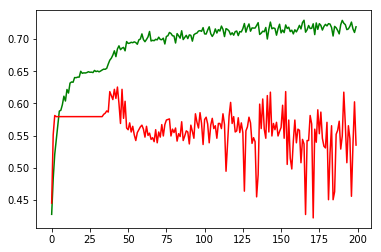

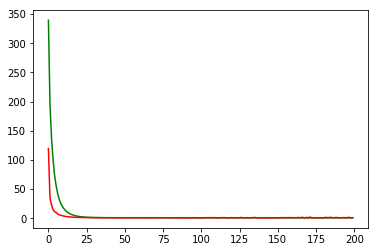

F1,score 0.36930455635491605
G-score: 0.4721436811682911
Accuracy 0.5353356877822337
Window: 140
[[452  24]
 [502 154]]
Vol pos 3.591076033853045
Vol neg 3.9801385394254143
Real Percentage of gain: 60.31987873538335
Percentage of gain: 0.07300283107524504
Total gain: 82.63920477717738
000000000000000000000000000000000000000000000000
Percentile:  0
[[294  18]
 [225  21]]
558/558 [==============================] - 0s 117us/step
[1.0940554867294954, 0.5645161283913479]
Percentile:  1
[[117   1]
 [156  64]]
338/338 [==============================] - 0s 110us/step
[0.9169947373620152, 0.5355029585798816]
Percentile:  2
[[28  3]
 [57 15]]
103/103 [==============================] - 0s 135us/step
[1.1427231888169225, 0.4174757281553398]
Percentile:  3
[[13  2]
 [29 36]]
80/80 [==============================] - 0s 160us/step
[0.672061288356781, 0.6125]
Percentile:  4
[[ 0  0]
 [34 17]]
51/51 [==============================] - 0s 155us/step
[0.8017162680625916, 0.3333333438518001]
00000000000000

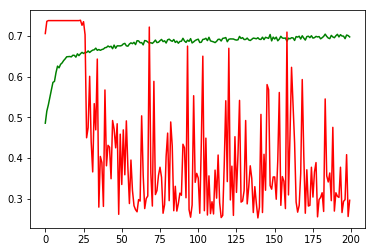

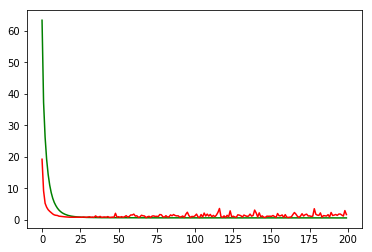

F1,score 0.21167161226508407
G-score: 0.3136446254402614
Accuracy 0.29593639578604447
Window: 140
[[228  69]
 [728 107]]
Vol pos 3.2398032669497465
Vol neg 4.800326849221162
Real Percentage of gain: -336.5642769912688
Percentage of gain: -2.420959721202386
Total gain: -2740.526404401101
000000000000000000000000000000000000000000000000
Percentile:  0
[[125  45]
 [230  60]]
460/460 [==============================] - 0s 110us/step
[1.3482205608616704, 0.40217391310826595]
Percentile:  1
[[ 57   3]
 [231  37]]
328/328 [==============================] - 0s 112us/step
[1.4058615637988578, 0.2865853658536585]
Percentile:  2
[[ 23  15]
 [189   6]]
233/233 [==============================] - 0s 112us/step
[2.046275244250318, 0.12446351931330472]
Percentile:  3
[[21  6]
 [66  4]]
97/97 [==============================] - 0s 148us/step
[2.242420787663804, 0.25773195876288657]
Percentile:  4
[[ 1  0]
 [11  0]]
12/12 [==============================] - 0s 305us/step
[2.78444242477417, 0.08333333581686

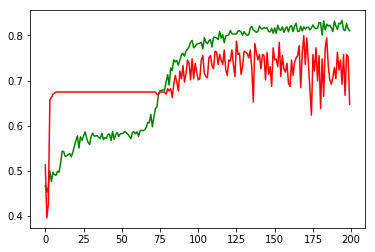

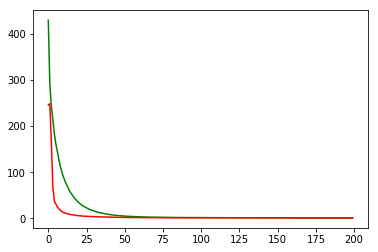

F1,score 0.6712328767123288
G-score: 0.6874154826352039
Accuracy 0.6479217607555297
Window: 140
[[118  15]
 [129 147]]
Vol pos 1.2750889745456595
Vol neg 0.7745302936132732
Real Percentage of gain: 118.03076674347083
Percentage of gain: 0.5534626307439815
Total gain: 226.36621597428845
000000000000000000000000000000000000000000000000
Percentile:  0
[[85 14]
 [72 25]]
196/196 [==============================] - 0s 125us/step
[0.6968470580723821, 0.5612244897959183]
Percentile:  1
[[25  1]
 [40 32]]
98/98 [==============================] - 0s 157us/step
[0.6460477162380608, 0.5816326530612245]
Percentile:  2
[[ 7  0]
 [17 58]]
82/82 [==============================] - 0s 135us/step
[0.518087733082655, 0.7926829253754964]
Percentile:  3
[[19]]
19/19 [==============================] - 0s 197us/step
[0.3023494780063629, 1.0]
Percentile:  4
[[12]]
12/12 [==============================] - 0s 285us/step
[0.14691045880317688, 1.0]
000000000000000000000000000000000000000000000000
Working on... ADB

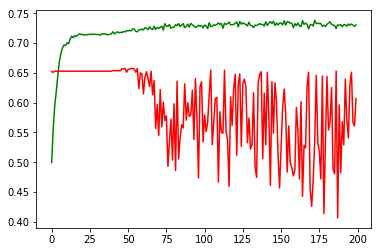

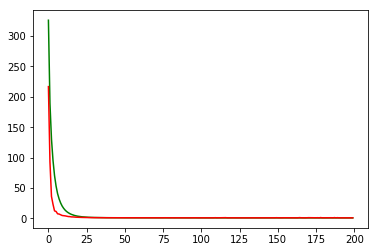

F1,score 0.7467273762094478
G-score: 0.2646148861815832
Accuracy 0.606890459048032
Window: 140
[[ 31 362]
 [ 83 656]]
Vol pos 3.0150871066523237
Vol neg 2.0574333991761606
Real Percentage of gain: 175.5911160286227
Percentage of gain: 1.021030900739183
Total gain: 1155.806979636755
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 31 236]
 [ 49 233]]
549/549 [==============================] - 0s 103us/step
[0.7891109334966524, 0.4808743169398907]
Percentile:  1
[[  0  78]
 [ 18 243]]
339/339 [==============================] - 0s 112us/step
[0.615492057659633, 0.7168141592920354]
Percentile:  2
[[  0  25]
 [ 15 118]]
158/158 [==============================] - 0s 109us/step
[0.5798906600928004, 0.7468354475649097]
Percentile:  3
[[ 0 23]
 [ 0 43]]
66/66 [==============================] - 0s 155us/step
[0.7561787881634452, 0.6515151515151515]
Percentile:  4
[[18]]
18/18 [==============================] - 0s 191us/step
[0.35440167784690857, 1.0]
000000000000000000000000000

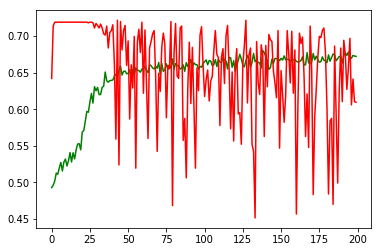

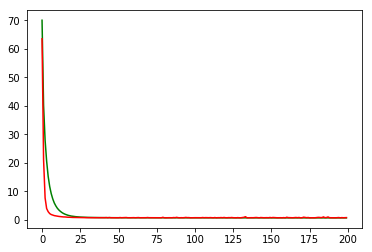

F1,score 0.7359617682198326
G-score: 0.4196434545311265
Accuracy 0.6095406364636371
Window: 140
[[ 74 244]
 [198 616]]
Vol pos 1.9436488587230967
Vol neg 1.8259172095440448
Real Percentage of gain: 138.81939637553606
Percentage of gain: 0.4717864893113683
Total gain: 534.0623059004689
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 64  99]
 [122 187]]
472/472 [==============================] - 0s 74us/step
[0.7588867454205529, 0.5317796612695113]
Percentile:  1
[[  4  51]
 [ 48 197]]
300/300 [==============================] - 0s 77us/step
[0.6892528597513835, 0.6699999992052714]
Percentile:  2
[[  1  25]
 [ 23 164]]
213/213 [==============================] - 0s 73us/step
[0.5936919249279399, 0.7746478881634457]
Percentile:  3
[[ 5 51]
 [ 5 64]]
125/125 [==============================] - 0s 89us/step
[0.6675592288970947, 0.5519999957084656]
Percentile:  4
[[ 0 17]
 [ 0  3]]
20/20 [==============================] - 0s 137us/step
[0.9835160970687866, 0.15000000596046448

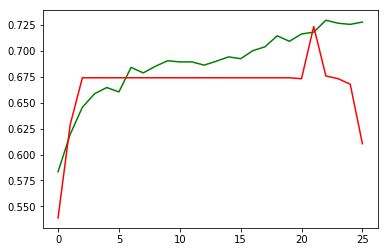

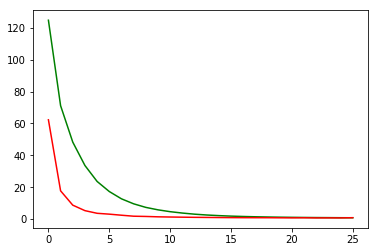

F1,score 0.6388206388206388
G-score: 0.6457138462961557
Accuracy 0.6104240270048485
Window: 140
[[301  68]
 [373 390]]
Vol pos 2.4108992378938314
Vol neg 2.6271044676635182
Real Percentage of gain: 16.037601700505693
Percentage of gain: 0.44821404871468723
Total gain: 507.37830314502594
000000000000000000000000000000000000000000000000
Percentile:  0
[[188  20]
 [159  88]]
455/455 [==============================] - 0s 151us/step
[0.7221647201003609, 0.6065934067244058]
Percentile:  1
[[108  22]
 [ 71 134]]
335/335 [==============================] - 0s 130us/step
[0.6583605175587668, 0.7223880597014926]
Percentile:  2
[[ 1 13]
 [87 91]]
192/192 [==============================] - 0s 148us/step
[0.7969428499539694, 0.4791666666666667]
Percentile:  3
[[ 1  9]
 [53 59]]
122/122 [==============================] - 0s 164us/step
[0.7536395631852697, 0.49180327899387627]
Percentile:  4
[[ 3  4]
 [ 2 17]]
26/26 [==============================] - 0s 190us/step
[0.6175975799560547, 0.76923078298568

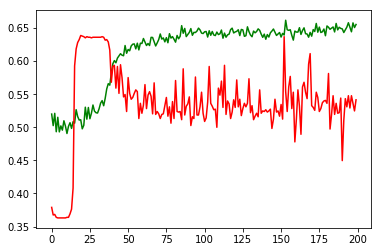

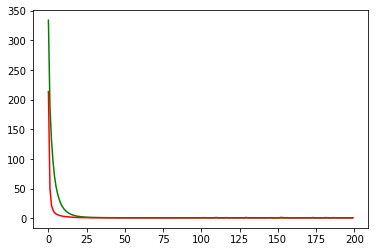

F1,score 0.6326963906581741
G-score: 0.5004022598034188
Accuracy 0.5415194373669978
Window: 140
[[166 245]
 [274 447]]
Vol pos 3.9875728148722143
Vol neg 2.1474259397542688
Real Percentage of gain: 77.72145296741274
Percentage of gain: 1.1747951173005318
Total gain: 1329.868072784202
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 61 145]
 [157 117]]
480/480 [==============================] - 0s 145us/step
[1.036678131421407, 0.37083333333333335]
Percentile:  1
[[ 36  89]
 [ 47 103]]
275/275 [==============================] - 0s 146us/step
[0.7672244533625516, 0.5054545454545455]
Percentile:  2
[[ 17   8]
 [ 65 157]]
247/247 [==============================] - 0s 163us/step
[0.5723694794573765, 0.7044534412955465]
Percentile:  3
[[16  1]
 [ 5 58]]
80/80 [==============================] - 0s 187us/step
[0.3934023201465607, 0.925]
Percentile:  4
[[35  2]
 [ 0 11]]
48/48 [==============================] - 0s 242us/step
[0.5091306865215302, 0.9583333333333334]
00000000000

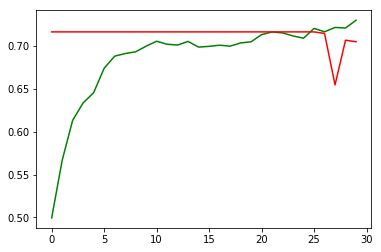

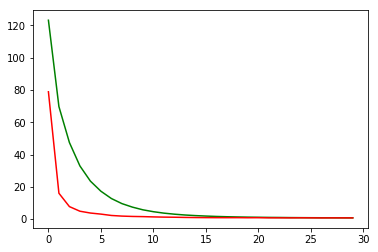

F1,score 0.8264033264033264
G-score: 0.09571527432266735
Accuracy 0.7049469973088995
Window: 140
[[  3 318]
 [ 16 795]]
Vol pos 2.731770950763285
Vol neg 3.3054014279411086
Real Percentage of gain: 236.17196472518447
Percentage of gain: 0.9504851075766528
Total gain: 1075.949141776771
000000000000000000000000000000000000000000000000
Percentile:  0
[[  3 134]
 [ 15 430]]
582/582 [==============================] - 0s 175us/step
[0.648629352808818, 0.7439862545003596]
Percentile:  1
[[  0  51]
 [  1 256]]
308/308 [==============================] - 0s 177us/step
[0.5749180324665912, 0.8311688303947449]
Percentile:  2
[[  0 120]
 [  0  64]]
184/184 [==============================] - 0s 175us/step
[0.8574956474096879, 0.34782608695652173]
Percentile:  3
[[ 0 13]
 [ 0 30]]
43/43 [==============================] - 0s 267us/step
[0.673615621965985, 0.6976744186046512]
Percentile:  4
[[12]]
12/12 [==============================] - 0s 391us/step
[0.5501430630683899, 1.0]
0000000000000000000000000

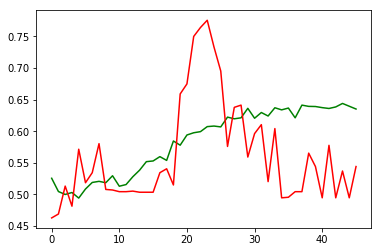

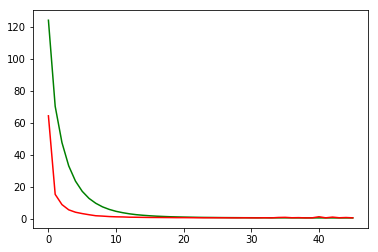

F1,score 0.6818742293464858
G-score: 0.3297925285510754
Accuracy 0.5441696119919261
Window: 140
[[ 63 509]
 [  7 553]]
Vol pos 2.773529582630261
Vol neg 3.7566256117681625
Real Percentage of gain: -150.641748399681
Percentage of gain: -0.20311359785523966
Total gain: -229.9245927721313
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 23 306]
 [  7 276]]
612/612 [==============================] - 0s 170us/step
[0.8040237773477642, 0.48856209150326796]
Percentile:  1
[[ 32  71]
 [  0 204]]
307/307 [==============================] - 0s 167us/step
[0.4714479665802822, 0.7687296416938111]
Percentile:  2
[[ 1 11]
 [ 0 70]]
82/82 [==============================] - 0s 232us/step
[0.416270828828579, 0.8658536585365854]
Percentile:  3
[[ 4 37]
 [ 0  0]]
41/41 [==============================] - 0s 301us/step
[0.8577328804062634, 0.09756097579147757]
Percentile:  4
[[ 3 83]
 [ 0  0]]
86/86 [==============================] - 0s 188us/step
[0.9008632316145786, 0.03488372093023256]


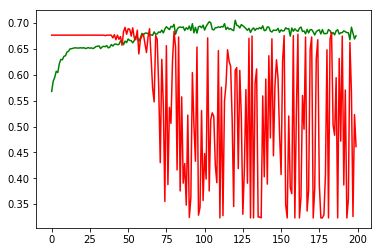

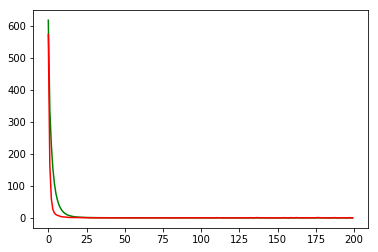

F1,score 0.5406626506024097
G-score: 0.456863117546047
Accuracy 0.4611307406804587
Window: 140
[[163 203]
 [407 359]]
Vol pos 1.3731226879857306
Vol neg 1.4661444456878678
Real Percentage of gain: -43.69735821218242
Percentage of gain: -0.15687108546028977
Total gain: -177.578068741048
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 85 103]
 [ 90  95]]
373/373 [==============================] - 0s 202us/step
[0.7540760160131684, 0.48257372678125193]
Percentile:  1
[[ 41  56]
 [106 100]]
303/303 [==============================] - 0s 193us/step
[0.7458434732440281, 0.4653465349977166]
Percentile:  2
[[ 36  32]
 [124 101]]
293/293 [==============================] - 0s 200us/step
[0.781211573109285, 0.46757679191058815]
Percentile:  3
[[ 1 11]
 [48 38]]
98/98 [==============================] - 0s 268us/step
[0.7787514146493406, 0.3979591836734694]
Percentile:  4
[[ 0  0]
 [39 24]]
63/63 [==============================] - 0s 204us/step
[0.8132994799386888, 0.3809523743296

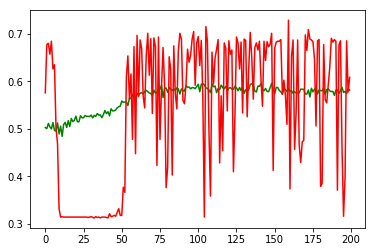

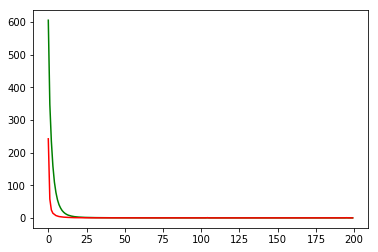

F1,score 0.6833452466047177
G-score: 0.6042258708847624
Accuracy 0.6086572427631688
Window: 140
[[211 145]
 [298 478]]
Vol pos 3.3557029670109992
Vol neg 3.31147082482358
Real Percentage of gain: 95.51210890493378
Percentage of gain: 0.746552799358421
Total gain: 845.0977688737325
000000000000000000000000000000000000000000000000
Percentile:  0
[[159  74]
 [142 157]]
532/532 [==============================] - 0s 192us/step
[0.679476717360934, 0.5939849615097046]
Percentile:  1
[[ 29  19]
 [105 191]]
344/344 [==============================] - 0s 202us/step
[0.679050069908763, 0.6395348837209303]
Percentile:  2
[[ 3 14]
 [24 66]]
107/107 [==============================] - 0s 244us/step
[0.7181898266355567, 0.6448598153123232]
Percentile:  3
[[ 4  7]
 [27 41]]
79/79 [==============================] - 0s 268us/step
[0.7650404949731464, 0.5696202554280245]
Percentile:  4
[[15 31]
 [ 0 22]]
68/68 [==============================] - 0s 268us/step
[0.6706700430196875, 0.5441176470588235]
0000000

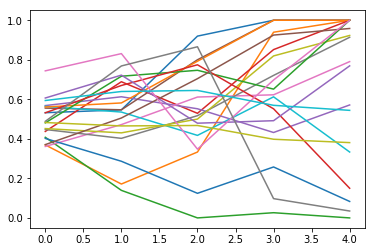

In [5]:
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]
earlyStopping=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    o+=1
    xtemp=price
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    scaler = MinMaxScaler() 
    scaler.fit(xtemp)
    MinMaxScaler(copy=True, feature_range=(0, 1))
    xtemp=scaler.transform(xtemp)
    
    
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        

        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        yvolatility=[]
        yprice=[]
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            
            if(s==-1):
                
                y.append(0)
            else:
                y.append(1)
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(xtemp[i])
        y=np.array(y)
        yvolatility=np.array(yvolatility)
        x=np.array(x)
        
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    


        lspace=[0.05,0.01]
        dropspace=[0.5]
        uspace=[64,128]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxu=0
        maxl=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                #print()
                for l in lspace:
                    
                   
                    print('=========================================================')
                    print('working on d,u and l',d,u,l)
                    
                    cvacclist=[]
                    #faccio cross validation
                    #start with 40% as train and 10% for validation and then i move in percentege
                    # 0-40 40-50
                    # 0-50 50-60
                    # 0-60 60-70 
                    #etc test set is completely external i do in some way error extimation changin the ticker
                    trainpoint=math.floor(len(x_tv)*0.40)
                    dimval=math.floor(trainpoint*0.25)
                    endval=trainpoint+dimval
                    model=buildModel(l,u,d)
                    bestepoch=200
                    epoch=200
                    for i in range(0,6):
                        #print('-----')
                        x_train=x_tv[0:trainpoint]
                        y_train=y_tv[0:trainpoint]
                        x_val=x_tv[trainpoint:endval]
                        y_val=y_tv[trainpoint:endval]

                        trainpoint=trainpoint+dimval
                        endval=endval+dimval
                        
                        x_train,y_train=smote(x_train,y_train)
                        if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                            x_val,y_val=smote(x_val,y_val)
                        else:
                            totu=totu+1

                        history=model.fit(x_train, y_train, epochs = 200,batch_size =128, verbose=0, validation_data=(x_val, y_val),
                                          shuffle=True,callbacks=[earlyStopping])
                        prediction=model.predict(x_val, batch_size=128, verbose=0)
                        for el in range(0,len(prediction)):
                            if(prediction[el]>0.5):
                                prediction[el]=1
                            else:
                                prediction[el]=0

                        if(i==5):
                            epoch=len(history.history['val_loss'])
                            
                       
                        
                        #i take the last one
                        #maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                        #USING G SCORE AS MODEL SELECTION METRIC
                        maxAcc=geometric_mean_score(y_val, prediction)
                        cvacclist.append(maxAcc)
                        reset_weights(model)
                        
                    cvacc=sum(cvacclist)/len(cvacclist)
                    if(cvacc>maxacc):
                        maxacc=cvacc
                        maxu=u
                        maxl=l
                        bestepoch=epoch
                    
                    
        bestmodel=model=buildModel(maxl,maxu,0.5)
        history=model.fit(x_tv, y_tv, epochs = bestepoch,batch_size =128, verbose=0, validation_data=(x_test, y_test),
                                          shuffle=True)
        prediction=model.predict(x_test, batch_size=128, verbose=0)
        for el in range(0,len(prediction)):
            if(prediction[el]>0.5):
                prediction[el]=1
            else:
                prediction[el]=0
            
        
        
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('Chart for BEST MODEL FOR:',files[o-1])
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        acctotal.append(history.history['val_acc'][len(history.history['val_acc'])-1])
        confmatrix=confusion_matrix(y_test, prediction)
        
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction)
        
        print('F1,score',CM)
        print('G-score:',valueacc)
        realacc=history.history['val_acc'][len(history.history['val_acc'])-1]
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print('Window:',t)
        print(confmatrix)
        print('Vol pos',sum(volr)/len(volr))
        print('Vol neg',sum(voln)/len(voln))
        percnegtotal.append(sum(volr)/len(volr))
        percpostotal.append(sum(voln)/len(voln))
        #build structure to plot distribution onver percentile
        chart=np.zeros(5)
        for r in range(0,len(y_test)):
            for v in range(0,5):
                if(yvolatilitytest[r]<min(yvolatility)+step+step*v and yvolatilitytest[r]>min(yvolatility)+step*v):
                    chart[v]+=1
        #plt.plot(chart)
        #plt.show()
        print('Real Percentage of gain:',(pricegain*100)/(sum(price.iloc[1:6]['open'])))
        pricegainlist.append((pricegain*100)/(sum(price.iloc[1:6]['open'])))
        print('Percentage of gain:',(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('Total gain:',len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        gainlist.append(len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        for g in range(0,len(distribution)):
            print('Percentile: ',g)
            tempscore=0
            if(len(distribution[g])>0):
                predictionp=model.predict(x_test[distribution[g]])
                for el in range(0,len(predictionp)):
                    if(predictionp[el]>0.5):
                        predictionp[el]=1
                    else:
                        predictionp[el]=0
                    
                print(confusion_matrix(y_test[distribution[g]], predictionp))
                print(model.evaluate(x_test[distribution[g]],y_test[distribution[g]]))
                tempscore=model.evaluate(x_test[distribution[g]],y_test[distribution[g]], verbose=0)
            chartscore.append(tempscore[1])    
        chartlist.append(chartscore)
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))
print('Mean gain over portfolio : ', sum(gainlist)/len(gainlist))
print('Real mean gain over portfolio',sum(pricegainlist)/len(pricegainlist))
#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
        

            

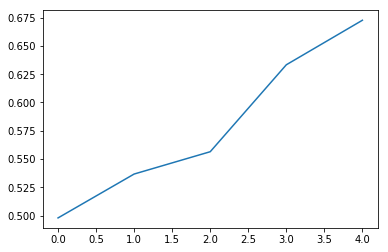

In [6]:
tot=np.zeros(5)
for st in range(0,len(chartlist)):
    tot=chartlist[st]+tot
    
tot=tot/20
plt.plot(tot)
plt.show()

In [ ]:
#print('ACCURACY on val:',maxacc)
        print('Test')
        model=buildModel(maxl,maxu)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs=20,shuffle=False, verbose=2,batch_size=100,validation_data=(x_test,y_test))
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        
        e=findMaxAccStep(history.history['val_acc'],history.history['val_loss'])
        model.fit(x_tv, y_tv, epochs=e,shuffle=False, verbose=0,batch_size=10)
        prediction=model.predict( x_test, batch_size=10, verbose=0, steps=None)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()

In [ ]:
tempacc=accstocksresults

In [ ]:
import operator
t=[0,0,0]
for i in range(0,len(tempacc)):
    t=np.add(t,tempacc[i])
print(t)
print(t/len(tempacc))

In [ ]:
Working on... AAPL
/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
Window: 2
[[249  81]
 [263 107]]
F1,score 0.38351254480286734
Accuracy: 0.5085714285714286
Window: 4
[[  0 323]
 [  0 376]]
F1,score 0.6995348837209303
Accuracy: 0.5379113018597997
Window: 6
[[243  85]
 [271 100]]
F1,score 0.35971223021582727
Accuracy: 0.4907010014306152
Window: 10
[[247  77]
 [234 140]]
F1,score 0.4737732656514382
Accuracy: 0.5544412607449857
Window: 16
[[257  67]
 [259 114]]
F1,score 0.4115523465703971
Accuracy: 0.5322812051649928
Window: 24
[[210  96]
 [253 136]]
F1,score 0.43800322061191627
Accuracy: 0.497841726618705
Window: 32
[[192 107]
 [217 178]]
F1,score 0.5235294117647058
Accuracy: 0.5331412103746398
Window: 42
[[219  76]
 [235 162]]
F1,score 0.5102362204724409
Accuracy: 0.5505780346820809
Window: 56
[[245  62]
 [227 155]]
F1,score 0.5175292153589315
Accuracy: 0.5805515239477503
Window: 66
[[  3 316]
 [  0 368]]
F1,score 0.6996197718631179
Accuracy: 0.5400291120815138
Window: 87
[[272  61]
 [197 153]]
F1,score 0.5425531914893618
Accuracy: 0.6222547584187409
Window: 100
[[188 135]
 [138 219]]
F1,score 0.6160337552742615
Accuracy: 0.5985294117647059
Window: 112
[[188 129]
 [134 227]]
F1,score 0.6331938633193863
Accuracy: 0.612094395280236
Window: 125
[[266  46]
 [236 127]]
F1,score 0.47388059701492535
Accuracy: 0.5822222222222222
Window: 140
[[315  24]
 [258  75]]
F1,score 0.3472222222222222
Accuracy: 0.5803571428571429
Window: 160
[[329  46]
 [172 121]]
F1,score 0.5260869565217392
Accuracy: 0.6736526946107785
Window: 175
[[365  15]
 [227  58]]
F1,score 0.3240223463687151
Accuracy: 0.6360902255639098
Window: 190
[[123 236]
 [ 57 246]]
F1,score 0.6267515923566879
Accuracy: 0.5574018126888217
Window: 205
[[ 27 314]
 [ 34 284]]
F1,score 0.6200873362445416
Accuracy: 0.47192716236722304
Window: 220
[[312   9]
 [294  41]]
F1,score 0.21298701298701297
Accuracy: 0.538109756097561
Window: 245
[[  0 260]
 [  0 391]]
F1,score 0.7504798464491362
Accuracy: 0.6006144393241167
Window: 260
[[246   7]
 [291 104]]
F1,score 0.41106719367588934
Accuracy: 0.5401234567901234
Window: 300
[[ 29 228]
 [ 48 335]]
F1,score 0.7082452431289641
Accuracy: 0.56875
Window: 350
[[127 109]
 [124 270]]
F1,score 0.6985769728331177
Accuracy: 0.6301587301587301
Window: 400
[[ 12 248]
 [ 17 343]]
F1,score 0.7213459516298634
Accuracy: 0.5725806451612904
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 45, 45, 45]
[0.5085714285714286, 0.5379113018597997, 0.4907010014306152, 0.5544412607449857, 0.5322812051649928, 0.497841726618705, 0.5331412103746398, 0.5505780346820809, 0.5805515239477503, 0.5400291120815138, 0.6222547584187409, 0.5985294117647059, 0.612094395280236, 0.5822222222222222, 0.5803571428571429, 0.6736526946107785, 0.6360902255639098, 0.5574018126888217, 0.47192716236722304, 0.538109756097561, 0.6006144393241167, 0.5401234567901234, 0.56875, 0.6301587301587301, 0.5725806451612904]
accuracy
accuracy
#old with f1 score in model selection
aapl=[0.5213675213675214, 0.5327635327635327, 0.5242165242165242, 0.5278174037089871, 0.5228571428571429, 0.5444126074498568, 0.5589080459770115, 0.5662824207492796, 0.5433526011560693, 0.5130434782608696, 0.5883211678832116, 0.6881405563689604, 0.6852941176470588, 0.5353982300884956, 0.5422222222222223, 0.4157973174366617, 0.4041916167664671, 0.44511278195488724, 0.48338368580060426, 0.5128983308042488, 0.6131498470948012, 0.6236559139784946, 0.6003110419906688, 0.627172195892575, 0.5826645264847512]
adbe=[0.5498575498575499, 0.5698005698005698, 0.5783475783475783, 0.6148359486447932, 0.6414285714285715, 0.6575931232091691, 0.6752873563218391, 0.6772334293948127, 0.6734104046242775, 0.6652173913043479, 0.6802919708029197, 0.6881405563689604, 0.7147058823529412, 0.7684365781710915, 0.7911111111111111, 0.8002980625931445, 0.7754491017964071, 0.7894736842105263, 0.8187311178247734, 0.8634294385432474, 0.8929663608562691, 0.9139784946236559, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.51994301994302, 0.5341880341880342, 0.550641940085592, 0.5428571428571428, 0.5464949928469242, 0.5544412607449857, 0.5502873563218391, 0.5749279538904899, 0.6034732272069464, 0.5892597968069666, 0.5883211678832116, 0.5791788856304986, 0.5441176470588235, 0.518463810930576, 0.46735905044510384, 0.45671641791044776, 0.4587706146926537, 0.4879518072289157, 0.5128593040847201, 0.5486322188449848, 0.4946401225114854, 0.5261538461538462, 0.557632398753894, 0.7215189873417721, 0.6270096463022508]
googl=[0.496551724137931, 0.5189655172413793, 0.5413793103448276, 0.538860103626943, 0.5657439446366782, 0.5538194444444444, 0.5679442508710801, 0.5856643356643356, 0.5421052631578948, 0.5475352112676056, 0.5808170515097691, 0.5508021390374331, 0.517921146953405, 0.4748201438848921, 0.42857142857142855, 0.3825136612021858, 0.36813186813186816, 0.3664825046040516, 0.37777777777777777, 0.3817504655493482, 0.37969924812030076, 0.43478260869565216, 0.5950095969289827, 0.5694716242661448, 0.592814371257485]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
tot=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
#new with accuracy in model selection
aapl=[0.5252976190476191, 0.5320417287630402, 0.5171385991058122, 0.5164179104477612, 0.5186846038863976, 0.5412293853073463, 0.551051051051051, 0.5542168674698795, 0.5370650529500757, 0.5174506828528073, 0.5114503816793893, 0.6380368098159509, 0.5169230769230769, 0.517774343122102, 0.47360248447204967, 0.415625, 0.41130298273155413, 0.45425867507886436, 0.47385103011093505, 0.4888535031847134, 0.5826645264847512, 0.5935483870967742, 0.5800653594771242, 0.6079734219269103, 0.5608108108108109]
adbe=[0.5484330484330484, 0.5669515669515669, 0.5740740740740741, 0.6105563480741797, 0.6371428571428571, 0.660458452722063, 0.6810344827586207, 0.6873198847262247, 0.6748554913294798, 0.6681159420289855, 0.6802919708029197, 0.6925329428989752, 0.7176470588235294, 0.7743362831858407, 0.794074074074074, 0.8107302533532041, 0.7859281437125748, 0.7984962406015037, 0.8157099697885196, 0.858877086494689, 0.8929663608562691, 0.9109062980030722, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.5155763239875389, 0.5179407176287052, 0.5226209048361935, 0.515625, 0.5258215962441315, 0.5196232339089482, 0.5125786163522013, 0.5031545741324921, 0.5134706814580031, 0.47217806041335453, 0.4384, 0.44694533762057875, 0.4338709677419355, 0.4359805510534846, 0.38925081433224756, 0.41475409836065574, 0.42504118616144976, 0.46357615894039733, 0.34608985024958405, 0.5284280936454849, 0.47386172006745364, 0.4864406779661017, 0.35738831615120276, 0.6888111888111889, 0.7135231316725978]
googl=[0.5153970826580226, 0.5340909090909091, 0.538961038961039, 0.551219512195122, 0.5765472312703583, 0.5620915032679739, 0.5891980360065466, 0.6042692939244664, 0.40594059405940597, 0.4685430463576159, 0.335, 0.7437185929648241, 0.7411764705882353, 0.7381756756756757, 0.7181663837011885, 0.4017094017094017, 0.29896907216494845, 0.5958549222797928, 0.2465277777777778, 0.23734729493891799, 0.653169014084507, 0.6513274336283186, 0.7809694793536804, 0.2340036563071298, 0.1303538175046555]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
totnew=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
plt.plot(trendwindowtime,tot,'r')
plt.plot(trendwindowtime,totnew,'g')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
trendwindowtime=[2,4,6,10,16,24,32,42,56,66,87,100,112,125,140,160,175,190,205,220,245,260,300,350,400]

a=[0.52192995, 0.53892941 ,0.54864634 ,0.55609265, 0.56913116 ,0.57756661,
 0.58810675, 0.60102703, 0.59058537, 0.57876397, 0.60943784 ,0.62656553,
 0.6155097,  0.57427969, 0.55731595, 0.51383136 ,0.5016358,  0.52225519,
 0.54818797, 0.57667761, 0.59511389 ,0.62464272, 0.68551664, 0.72796092,
 0.70062214]
b=[0.51760779 ,0.52952612, 0.53490195, 0.53742601, 0.54627483 ,0.54998215,
 0.56540344, 0.58600154 ,0.58753407 ,0.57731507, 0.594899   ,0.5961274,
 0.59153927 ,0.58697463, 0.55879766, 0.53795722, 0.53334514 ,0.56295701,
 0.58163702 ,0.60455733, 0.62554647 ,0.65463482 ,0.71007133 ,0.7335257,
 0.68877474]
c=[0.52099555, 0.5337735 , 0.53833449, 0.54061983 ,0.55396823 ,0.55690408,
 0.57024055, 0.58414245, 0.59335293, 0.58858148, 0.61281755, 0.61071544,
 0.61790589, 0.63407592 ,0.62393464 ,0.61431855, 0.60202487 ,0.6046186,
 0.60656568 ,0.62321505 ,0.64674124, 0.65245534, 0.73430844, 0.76789561,
 0.74018119]
d=[0.52282555, 0.53986176, 0.54463966 ,0.54846378 ,0.56177553 ,0.58579719,
 0.59445897 ,0.59920915, 0.5909525 , 0.58121757, 0.59267087 ,0.59938036,
 0.59060086 ,0.58884745, 0.55975116 ,0.53407032, 0.52909452,0.54840958,
 0.57406494, 0.60228516, 0.62788511, 0.65007699 ,0.68774144, 0.73405107,
 0.70384762]
e=[0.52243865, 0.53663027 ,0.54537545, 0.55677058 ,0.5728499 , 0.58627962,
 0.60346285 ,0.61262476, 0.61037032 ,0.60298479 ,0.62605434, 0.66117335,
 0.65966471 ,0.62698978, 0.6261062 , 0.57038208, 0.56864994 ,0.5883435,
 0.60814613, 0.62989858, 0.64787428 ,0.67262909 ,0.7058909 , 0.75028496,
 0.72055658]
f=[0.5238604 , 0.53881766, 0.54561249, 0.5536881 , 0.5689674 , 0.59312321,
 0.60452586 ,0.6120317 , 0.59615891 ,0.58592951, 0.62335766,0.60526324,
 0.59779412 ,0.59643011, 0.56313606, 0.53631025 ,0.53048607 ,0.56524198,
 0.57685531, 0.60529159, 0.62404229 ,0.64843554, 0.70316929 ,0.74870518,
 0.72055658]
g=[0.52246465, 0.53817575, 0.54286319, 0.54822634 ,0.56302575 ,0.57261693,
 0.58757837, 0.60089967 ,0.59200024, 0.58167815, 0.59812454, 0.60119231,
 0.59054402 ,0.58859025, 0.55670147 ,0.52958314, 0.52837084, 0.55018158,
 0.57541237, 0.59998367, 0.62075483 ,0.64301379, 0.6930744 ,0.73912468,
 0.70964223]
plt.plot(trendwindowtime,a,'r')
plt.plot(trendwindowtime,b,'g')
plt.plot(trendwindowtime,c,'b')
plt.plot(trendwindowtime,d,'y')
plt.plot(trendwindowtime,e,'c')
plt.plot(trendwindowtime,f,'b')
plt.plot(trendwindowtime,g,'m')
plt.show()





In [ ]:
space=np.concatenate(((np.logspace(0,3,15)),np.logspace(-4,4,10)))
print(space)
plt.plot(space)
plt.show()